In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  5901k      0  0:00:13  0:00:13 --:--:-- 6356k


Found 15000 files belonging to 2 classes.
Using 12000 files for training.
Found 15000 files belonging to 2 classes.
Using 3000 files for validation.
Found 25000 files belonging to 2 classes.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
tf.one_hot (TFOpLambda)      (None, None, 10000)       0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                2568448   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,568,513
Trainable params: 2,568,513
Non-trainable pa

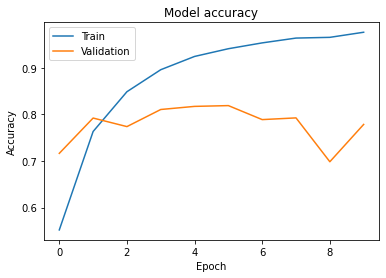

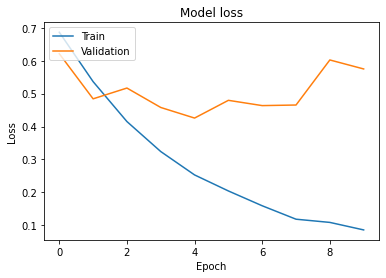

In [2]:
##### Training basic sequence model 

import os, pathlib, shutil, random
from tensorflow import keras

batch_size = 32
# Remove the text after this number of words(from the top max_features most common words)
max_length = 150
# no of words to consider as features
max_tokens = 10000
#restricting training samples to 100
num_train_samples = 100
#validating on 10,000 samples
num_val_samples = 10000

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples_cat = int(num_val_samples/2)
    val_files = files[-num_val_samples_cat:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=1337)

train_ds = train_ds.take(num_train_samples)

val_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=1337)

val_ds = val_ds.take(num_val_samples)

test_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)

text_only_train_ds = train_ds.map(lambda x, y: x)

from tensorflow.keras import layers

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y),
                            num_parallel_calls=4)

int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y),
                        num_parallel_calls=4)

int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y),
                          num_parallel_calls=4)

import tensorflow as tf

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras", save_best_only=True)
]

history = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=callbacks
)

model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                73984     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
100/100 [==============================] - 10s 79ms/step - loss: 0.6520 - accuracy: 0.6012 - val_loss: 0

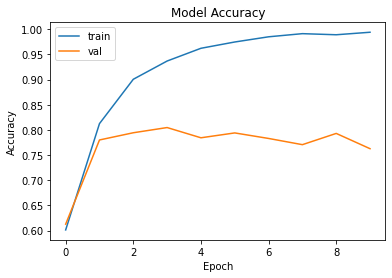

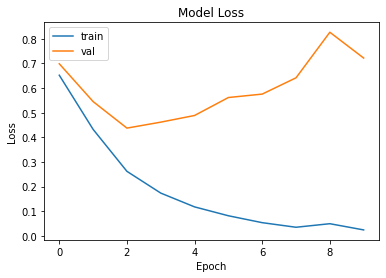

In [3]:
##### Training a model using EMBEDDING LAYER from scratch


import matplotlib.pyplot as plt

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]

history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


--2024-05-03 21:27:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-05-03 21:27:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-05-03 21:27:26--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.4’

10

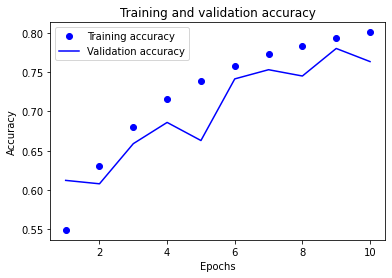

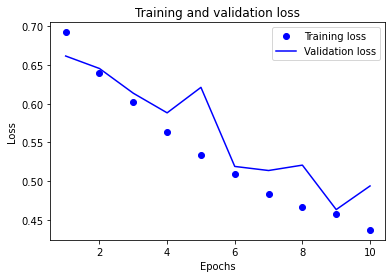

In [4]:
##### Training a model using pretrained word embedding

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

embedding_dim = 100
max_tokens = 10000
max_len = 150
num_samples = 100
validation_samples = 10000

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
word_index = {k: v for k, v in word_index.items() if v < max_tokens}

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]


history = model.fit(int_train_ds.take(num_samples).cache(),
          validation_data=int_val_ds.take(validation_samples).cache(),
          epochs=10, callbacks=callbacks)

model = keras.models.load_model("glove_embeddings_sequence_model.keras")
_, test_acc = model.evaluate(int_test_ds.take(validation_samples))
print(f"Test acc: {test_acc:.3f}")

# Plotting training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Found 25000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 [==============================] - 19s 111ms/step - loss: 0.5986 - accuracy: 0.6645 - val_loss: 0.4471 - val_accuracy: 0.7960
Epoch 2/10
125/125 [==============================] - 14s 108ms/step - loss: 0.3458 - accuracy: 0.8615 - val_loss: 0.4423 - val_accuracy: 0.8150
Epoch 3/10
125/125 [==============================] - 12s 94ms/step - loss: 0.2155 - accuracy: 0.9200 - val_loss: 0.3989 - val_accuracy: 0.8260
Epoch 4/10
125/125 [==============================] - 12s 96ms/step - loss: 0.1274 - accuracy: 0.9563 - val_loss: 0.4262 - val_accuracy: 0.8130
Epoch 5/10
125/125 [==============================] - 12s 93ms/step - loss: 0.0851 - accuracy: 0.9735 - val_loss: 0.7981 - val_accuracy: 0.7830
Epoch 6/10
125/125

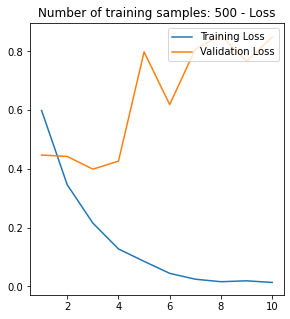

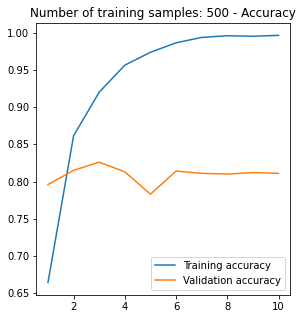

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 [==============================] - 18s 109ms/step - loss: 0.6070 - accuracy: 0.6585 - val_loss: 0.4639 - val_accuracy: 0.7980
Epoch 2/10
125/125 [==============================] - 12s 96ms/step - loss: 0.3600 - accuracy: 0.8562 - val_loss: 0.4045 - val_accuracy: 0.8420
Epoch 3/10
125/125 [==============================] - 11s 89ms/step - loss: 0.2223 - accuracy: 0.9162 - val_loss: 0.4917 - val_accuracy: 0.8160
Epoch 4/10
125/125 [==============================] - 12s 93ms/step - loss: 0.1380 - accuracy: 0.9507 - val_loss: 0.4113 - val_accuracy: 0.8130
Epoch 5/10
125/125 [==============================] - 11s 90ms/step - loss: 0.0841 - accuracy: 0.9735 - val_loss: 0.6337 - val_accuracy: 0.7950
Epoch 6/10
125/125 [==============================] - 12s 93ms/step - loss: 0.0405 - accuracy: 0.9887 - val_loss: 0.6902 - val_accura

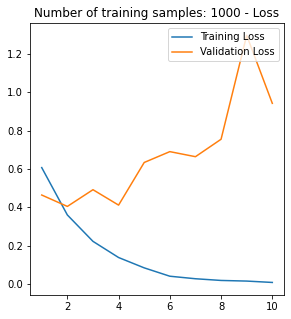

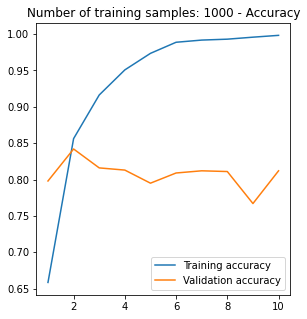

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 [==============================] - 18s 108ms/step - loss: 0.6248 - accuracy: 0.6400 - val_loss: 0.4716 - val_accuracy: 0.7880
Epoch 2/10
125/125 [==============================] - 12s 94ms/step - loss: 0.3723 - accuracy: 0.8475 - val_loss: 0.3942 - val_accuracy: 0.8300
Epoch 3/10
125/125 [==============================] - 12s 94ms/step - loss: 0.2393 - accuracy: 0.9130 - val_loss: 0.6284 - val_accuracy: 0.7520
Epoch 4/10
125/125 [==============================] - 12s 93ms/step - loss: 0.1509 - accuracy: 0.9452 - val_loss: 0.4266 - val_accuracy: 0.8040
Epoch 5/10
125/125 [==============================] - 11s 90ms/step - loss: 0.0946 - accuracy: 0.9682 - val_loss: 0.8498 - val_accuracy: 0.7410
Epoch 6/10
125/125 [==============================] - 12s 92ms/step - loss: 0.0464 - accuracy: 0.9852 - val_loss: 0.5367 - val_accura

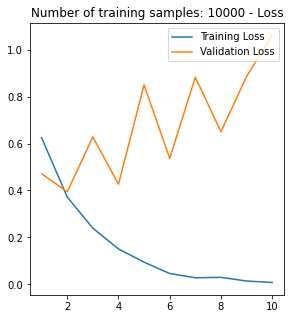

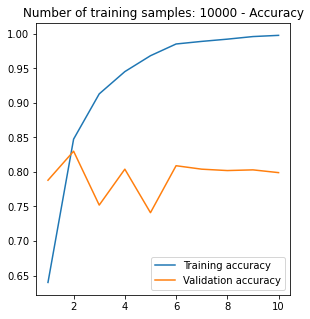

In [5]:
#### Using different training samples for embedding layer model

import os, pathlib, shutil, random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 32
max_length = 150
max_tokens = 10000
num_val_samples = 10000

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples_cat = int(num_val_samples/2)
    val_files = files[-num_val_samples_cat:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

test_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)

text_only_train_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=1337).map(lambda x, y: x)

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

text_vectorization.adapt(text_only_train_ds)

for num_train_samples in [500, 1000, 10000]:
    train_ds = keras.preprocessing.text_dataset_from_directory(
        "aclImdb/train",
        batch_size=batch_size,
        validation_split=0.2,
        subset='training',
        seed=1337
    ).take(num_train_samples)

    val_ds = keras.preprocessing.text_dataset_from_directory(
        "aclImdb/train",
        batch_size=batch_size,
        validation_split=0.2,
        subset='validation',
        seed=1337
    ).take(num_val_samples)

    int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
    int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
    int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = layers.Embedding(
        input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)]

    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

    model = keras.models.load_model("embeddings_bidir_gru.keras")
    test_acc = model.evaluate(int_test_ds)[1]
    print(f"Number of training samples: {num_train_samples} - Test accuracy: {test_acc:.3f}")
    
 

    # Plotting the training and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Number of training samples: {num_train_samples} - Loss')

    plt.show()
    
    #Plotting the training and validation accuracies
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs_range = range(1, len(acc) + 1)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label='Training accuracy')
    plt.plot(epochs_range, val_acc, label='Validation accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Number of training samples: {num_train_samples} - Accuracy')
    plt.show()



Found 400000 word vectors.
Found 25000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 [==============================] - 19s 109ms/step - loss: 0.6032 - accuracy: 0.6645 - val_loss: 0.4491 - val_accuracy: 0.7990
Epoch 2/10
125/125 [==============================] - 12s 94ms/step - loss: 0.3447 - accuracy: 0.8620 - val_loss: 0.4628 - val_accuracy: 0.8060
Epoch 3/10
125/125 [==============================] - 12s 92ms/step - loss: 0.2080 - accuracy: 0.9255 - val_loss: 0.4858 - val_accuracy: 0.8010
Epoch 4/10
125/125 [==============================] - 11s 90ms/step - loss: 0.1238 - accuracy: 0.9578 - val_loss: 0.4029 - val_accuracy: 0.8280
Epoch 5/10
125/125 [==============================] - 11s 91ms/step - loss: 0.0710 - accuracy: 0.9760 - val_loss: 0.7404 - val_accuracy:

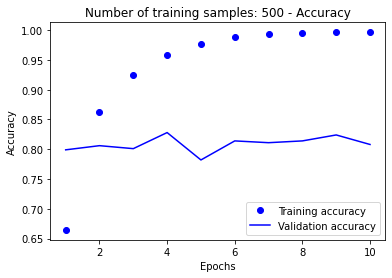

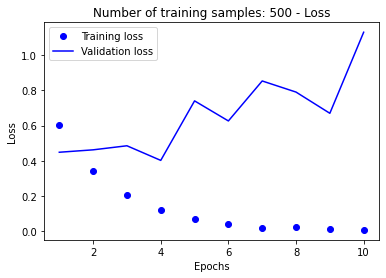

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 [==============================] - 18s 106ms/step - loss: 0.6205 - accuracy: 0.6363 - val_loss: 0.4764 - val_accuracy: 0.7760
Epoch 2/10
125/125 [==============================] - 12s 93ms/step - loss: 0.3717 - accuracy: 0.8457 - val_loss: 0.4274 - val_accuracy: 0.8280
Epoch 3/10
125/125 [==============================] - 12s 93ms/step - loss: 0.2276 - accuracy: 0.9147 - val_loss: 0.4650 - val_accuracy: 0.8090
Epoch 4/10
125/125 [==============================] - 11s 88ms/step - loss: 0.1356 - accuracy: 0.9528 - val_loss: 0.4030 - val_accuracy: 0.8280
Epoch 5/10
125/125 [==============================] - 12s 92ms/step - loss: 0.0737 - accuracy: 0.9770 - val_loss: 0.6976 - val_accuracy: 0.7720
Epoch 6/10
125/125 [==============================] - 11s 87ms/step - loss: 0.0382 - accuracy: 0.9887 - val_loss: 0.5812 - val_accura

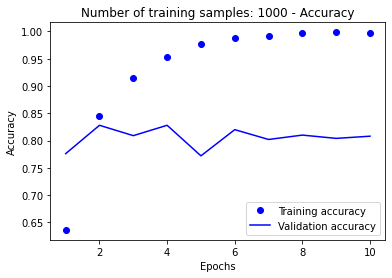

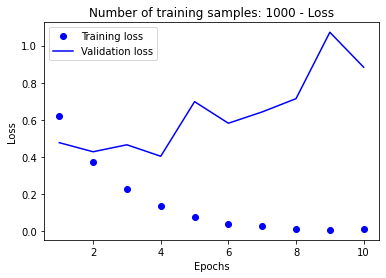

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Epoch 1/10
125/125 [==============================] - 18s 107ms/step - loss: 0.6104 - accuracy: 0.6597 - val_loss: 0.4568 - val_accuracy: 0.7940
Epoch 2/10
125/125 [==============================] - 11s 91ms/step - loss: 0.3638 - accuracy: 0.8515 - val_loss: 0.4055 - val_accuracy: 0.8290
Epoch 3/10
125/125 [==============================] - 12s 94ms/step - loss: 0.2222 - accuracy: 0.9185 - val_loss: 0.4571 - val_accuracy: 0.8120
Epoch 4/10
125/125 [==============================] - 11s 85ms/step - loss: 0.1318 - accuracy: 0.9540 - val_loss: 0.4412 - val_accuracy: 0.8110
Epoch 5/10
125/125 [==============================] - 12s 93ms/step - loss: 0.0736 - accuracy: 0.9770 - val_loss: 0.6216 - val_accuracy: 0.7740
Epoch 6/10
125/125 [==============================] - 12s 92ms/step - loss: 0.0414 - accuracy: 0.9855 - val_loss: 0.5473 - val_accura

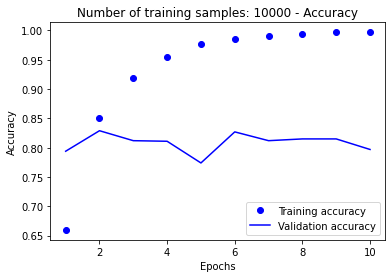

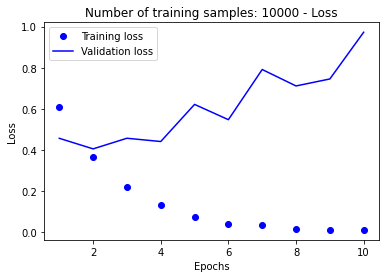

In [6]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

embedding_dim = 100
max_tokens = 10000
max_len = 150
num_samples = 100
validation_samples = 10000

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
word_index = {k: v for k, v in word_index.items() if v < max_tokens}

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

test_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)

text_only_train_ds = keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=1337).map(lambda x, y: x)

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

text_vectorization.adapt(text_only_train_ds)

for num_train_samples in [500, 1000, 10000]:
    train_ds = keras.preprocessing.text_dataset_from_directory(
        "aclImdb/train",
        batch_size=batch_size,
        validation_split=0.2,
        subset='training',
        seed=1337
    ).take(num_train_samples)

    val_ds = keras.preprocessing.text_dataset_from_directory(
        "aclImdb/train",
        batch_size=batch_size,
        validation_split=0.2,
        subset='validation',
        seed=1337
    ).take(num_val_samples)

    int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
    int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
    int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = layers.Embedding(
        input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

    model = keras.models.load_model("glove_embeddings_sequence_model.keras")
    test_acc = model.evaluate(int_test_ds)[1]
    print(f"Number of training samples: {num_train_samples} - Test accuracy: {test_acc:.3f}")
    
 

    # Plotting training and validation accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'Number of training samples: {num_train_samples} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plotting training and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Number of training samples: {num_train_samples} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

